**Background**: E10 fuels (gasoline with 10% volume of ethanol blended) have been widely applied in the United States. U.S. Environmental Protection Agency (EPA) thus wanto to evaluate whether the blended ethanol affects fuel emissions. They led a big project that tested emissions from a combinations of 27 test fuels and 15 high-sales light duty vehicles. The main product of this project was the [EPAct/V2/E-89 dataset](https://www.epa.gov/moves/epactv2e-89-tier-2-gasoline-fuel-effects-study). Their [analysis](https://saemobilus.sae.org/content/2015-01-1072) on this dataset concludes that ethanol increases PM emission. This conclusion has remain controversial since then. Here I did my anlaysis of the dataset and show that this conclusion does not hold.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')
sns.set(style='ticks', context='talk', color_codes=True)
sns.color_palette('husl')
%matplotlib inline

In [2]:
emission = pd.read_csv('data/tests.csv', index_col=0)
emission.head(5)

,Emission
Test Number,
EPA-CCOB-P3-2-T1,4.333699
EPA-TCAM-P3-7-T1,2.282023
EPA-HODY-P3-15-T1,2.670861
EPA-DCAL-P3-9-T1,3.693179
EPA-FEXP-P3-8-T1,2.697441


In [3]:
emission['Vehicle'] = emission.index.str.split('-').str[1]
emission['Fuel'] = emission.index.str.split('-').str[-2].str.replace('[^0-9]', '').astype(int)

In [4]:
emission = emission.groupby(['Vehicle', 'Fuel'], as_index=False).mean()
emission['fuel_rank'] = emission.groupby('Vehicle')['Emission'].rank()
emission['vehicle_rank'] = emission.groupby('Fuel')['Emission'].rank()
emission = emission[emission['Emission']<50]    # Remove outliers
emission.shape

(404, 5)

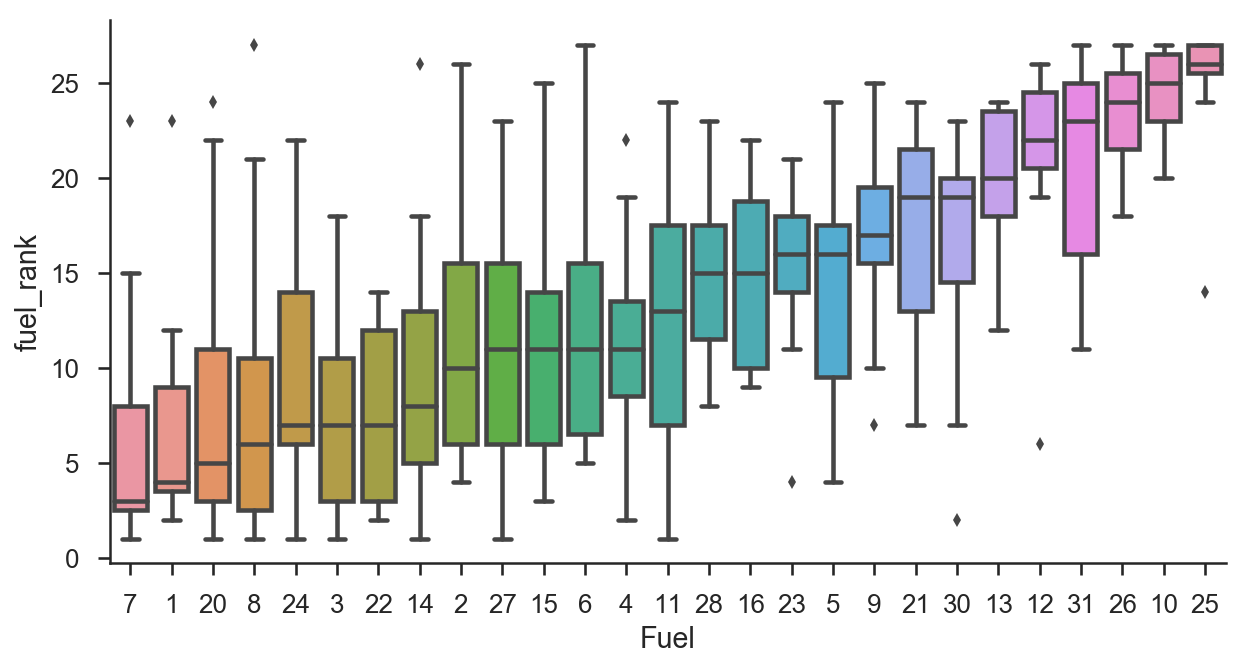

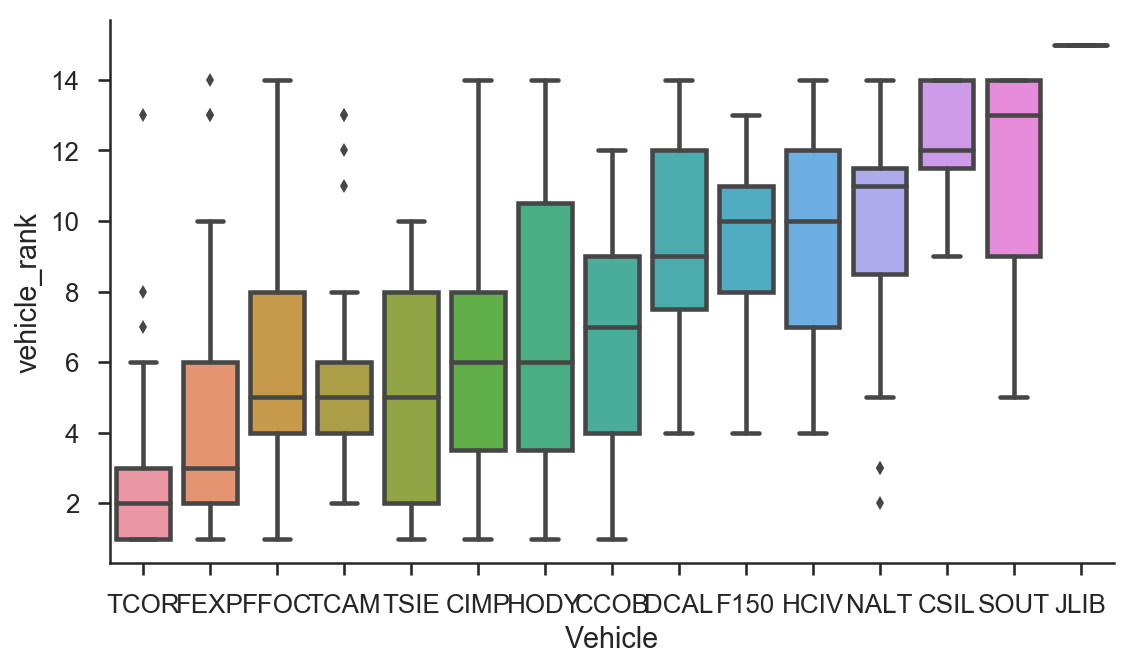

In [5]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=emission[['Fuel', 'Vehicle', 'fuel_rank', 'Emission']], x='Fuel', y='fuel_rank',
           order=emission[['Fuel', 'fuel_rank']].groupby('Fuel')['fuel_rank'].median().sort_values().index)
sns.despine()

plt.figure(figsize=(9, 5))
sns.boxplot(data=emission[['Fuel', 'Vehicle', 'fuel_rank', 'Emission', 'vehicle_rank']], x='Vehicle', y='vehicle_rank', 
           order=emission[['Vehicle', 'vehicle_rank']].groupby('Vehicle')['vehicle_rank'].median().sort_values().index)
sns.despine()

In [6]:
fuel_emis = emission[['Fuel', 'Emission']].groupby('Fuel').mean()

In [7]:
fuel_props = pd.read_csv('data/fuel_property.csv', index_col=0)

A simple scatter plot of PM emission against fuel ethanol content hints that there may not be direct relationship between the two. Is there any other way to confirm this guess?

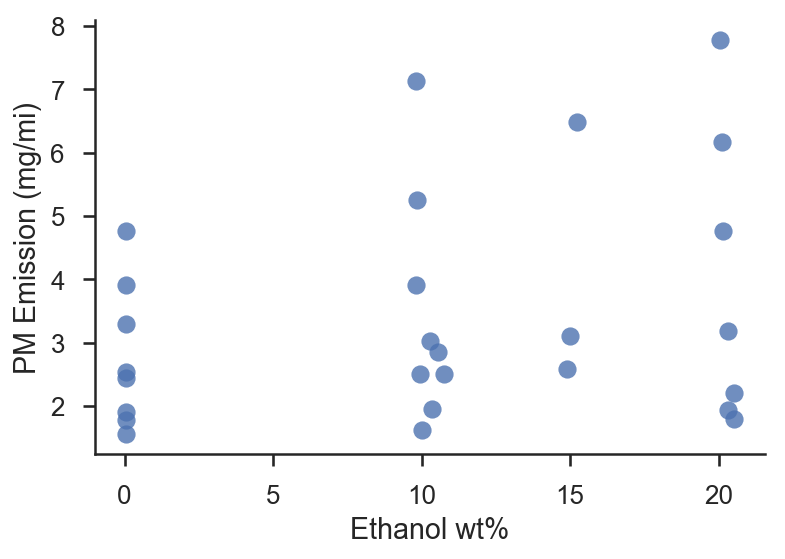

In [8]:
sns.regplot(fuel_props['Ethanol'].values, fuel_emis.values.ravel(), fit_reg=False)
sns.despine()
plt.gca().set_xlabel('Ethanol wt%')
plt.gca().set_ylabel('PM Emission (mg/mi)')

## Looking at Detailed Hydrocarbon Analysis (DHA) results

DHA provides detailed composition information for each test fuel. However, each fuel contains >200 hydrocarbons, which will cause overfitting if they are all used for PM emission modeling. Each hydrocarbon is categorized into a particular group of hydrocarbons (e.g. methane is a paraffin). The DHA results contains ~10 hydrocarbon groups. Is it possible to use only hydrocarbon groups for the analysis?

Load data for hydrocarbon group and molecular weight of each hydrocarbon compound.

In [9]:
comp_group = pd.read_csv('data/compounds.csv', index_col=0)
comp_group.head(3)

,Group,MW
c6-diolefin-1,Di-Olefins,82.146
"trans-1,3-pentadiene",Di-Olefins,68.119
"2-methyl-1,3-butadiene",Di-Olefins,68.119


Load hydrocarbon weight fractions for test fuels.

In [10]:
dha = pd.read_csv('data/dha.csv', index_col=0)
dha['Group'] = comp_group['Group']

In [11]:
# Calculate hydrocarbon mole fractions for test fuels
dha_mol = dha.iloc[:,:-1].div(comp_group['MW'], axis=0)
dha_mol = dha_mol.div(dha_mol.sum(), axis=1) * 100
dha_mol = dha_mol.dropna()    # Drop unidentified components

# Calculate product of mole fraction and molecular weight for each hydrocarbon compound
dha_mol_mw = dha_mol.multiply(comp_group['MW'], axis=0)
dha_mol_mw['Group'] = dha['Group'].str.lower()

# Calculate product of mole fraction and molecular weight for each hydrocarbon group
group_mol_mw = dha_mol_mw.groupby('Group').sum()

# Calculate hydrocarbon mole fractions for each hydrocarbon group
dha_mol['Group'] = dha['Group'].str.lower() 
group_mol = dha_mol.groupby('Group').sum()

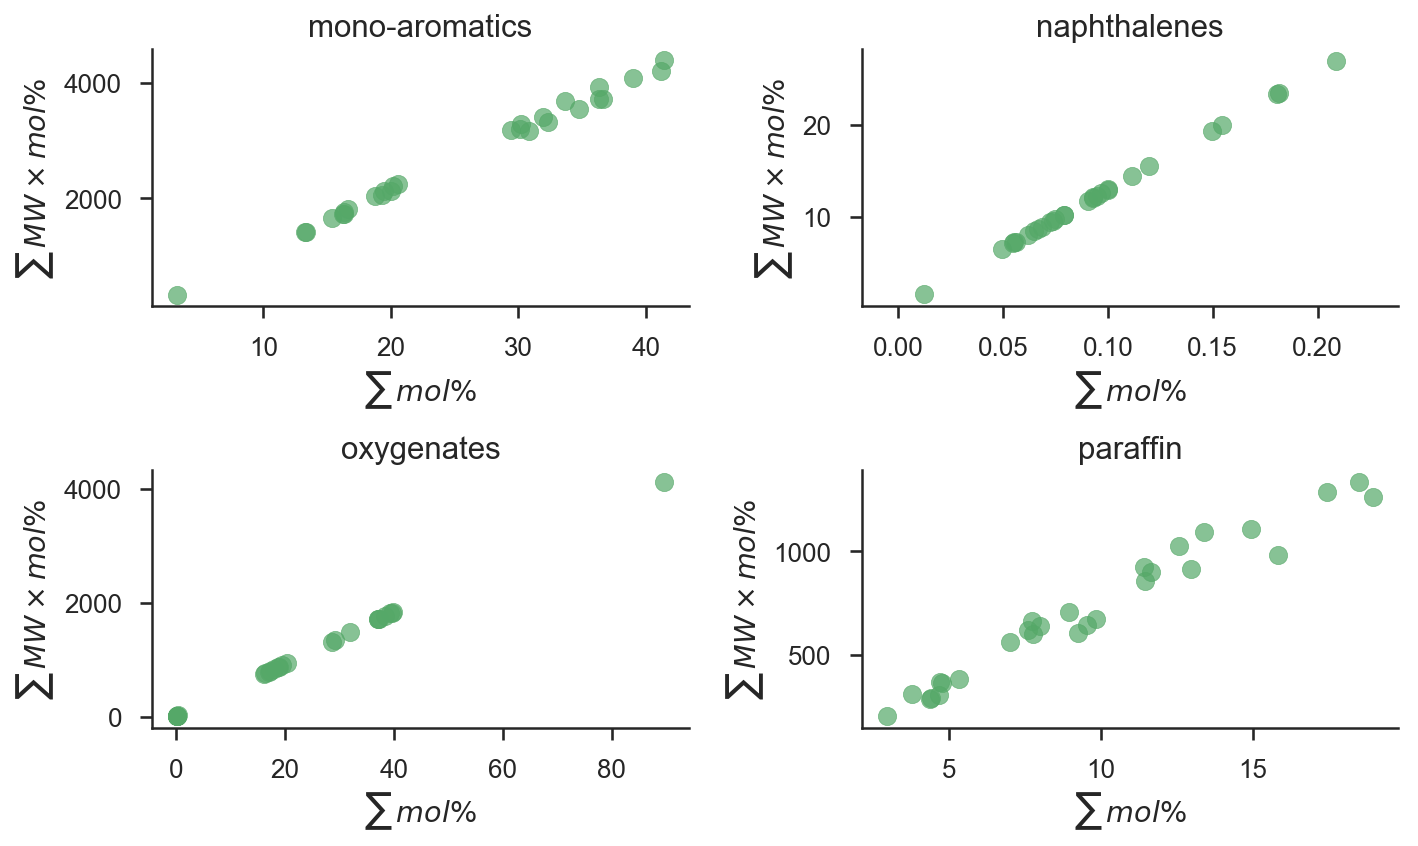

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
comps = ['mono-aromatics', 'naphthalenes', 'oxygenates', 'paraffin']
for comp, axis in zip(comps, ax.ravel()):
    axis.scatter(group_mol.loc[comp], group_mol_mw.loc[comp], color='g', alpha=0.7)
    axis.set_title(comp)
    axis.set_xlabel(r'$\sum\,mol\%$')
    axis.set_ylabel(r'$\sum\,MW \times mol\%$')
    sns.despine()
plt.tight_layout()

The above figure shows that the sum of product of molecular weight and mole fractions is almost linearly dependent on the mole fractions. This relationship holds for most hydrocarbon groups (not perfectly for paraffin due to the massive hydrocarbons present in this group). This observation demonstrates that relative hydrocarbon composition in each hydrocarbon group almost remains the same for each test fuel. For example, both methane and ethane are paraffins. The above figure shows that if the amount of methane in fuel 2 is twice of that of methane in fuel 1, this ratio will hold for other hydrocarbons in the same hydrocarbon group (paraffin in this example). In other words, the amount of ethane in fuel 2 is also twice of that of ethane in fuel 1. **The difference in hydrocarbon composition among all test fuels can be described by the differences in composition of hydrocarbon groups.** Hence it is acceptable to use compositions of hydrocarbon groups for this data analysis.

### What are the important hydrocarbon groups for explaining PM emissions?
To answer this questions, two algorithms are used: Lasso and random forests. The former captures linear relationship between the target and the features while the latter captures nonlinear relationship. The results of the two algorithms are then compared. Note that the features should be normalized before being fed to Lasso to avoid issues caused by different scales of the features. In comparison, random forests does not suffer from this issue.

In [13]:
y = fuel_emis.copy()
X_group = group_mol.T
X_group.index = X_group.index.str.split().str[-1].astype(int)
X_group = X_group.reindex(y.index)

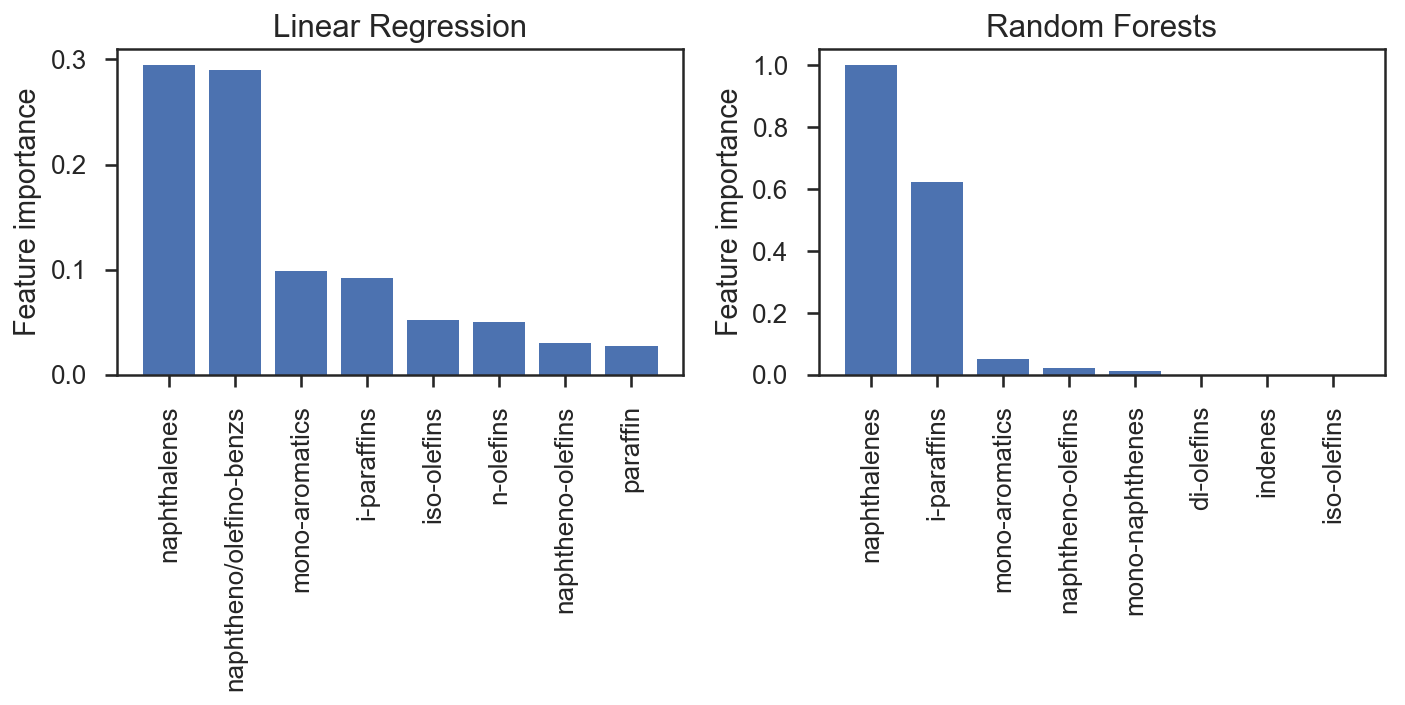

In [14]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_group, y)
importance = rf.feature_importances_
ind = np.argsort(-importance)

lasso = LassoCV()
lasso_pipe = Pipeline([('scl', StandardScaler()), ('lasso', lasso)])
lasso_pipe.fit(X_group, y)
coef = lasso_pipe.steps[-1][-1].coef_

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes.ravel()
ax1.bar(range(8), importance[ind[:8]])
ax1.set_xticks(range(8))
ax1.set_xticklabels(X_group.columns[ind[:8]].str.split('_').str[0].values, rotation=90)
ax1.set_ylabel('Feature importance')
ax1.set_title('Linear Regression')

ax2.bar(range(2,10), np.abs(coef)[(-np.abs(coef)).argsort()[:8]])
ax2.set_xticks(range(2,10))
ax2.set_xticklabels(X_group.columns[(-np.abs(coef)).argsort()[:8]].str.split('_').str[0], rotation=90)
ax2.set_ylabel('Feature importance')
ax2.set_title('Random Forests')

fig.tight_layout()

The two algorithms agree well in that:
* Naphthalenes are the most important hydrocarbon group for explaining PM emission.
* Oxygenates (ethanol is the only oxygenate in this dataset) are not important for explaining PM emission.  

There maybe 3 reasons why naphthalenes is important for predicting fuel PM emission:
1. Naphthalenes are the dominant hydrocarbons in the fuels.
2. Naphthalenes content varies significantly across the fuels.
3. There is latent chemical relationship between naphthalenes and PM formation.

I will investigate these reasons in the following sections.

**Are naphthalenes the dominant hydrocarbons in the fuels?**

In [15]:
fuel_group = dha.groupby('Group').sum()
fuel_group.index = fuel_group.index.str.lower()
fuel_group

,Fuel 1,Fuel 2,Fuel 3,Fuel 4,Fuel 5,Fuel 6,Fuel 7,Fuel 8,Fuel 9,Fuel 10,...,Fuel 22,Fuel 23,Fuel 24,Fuel 25,Fuel 26,Fuel 27,Fuel 28,Fuel 29,Fuel 30,Fuel 31
Group,,,,,,,,,,,,,,,,,,,,,
di-olefins,0.027,0.024,0.025,0.023,0.025,0.025,0.021,0.020,0.023,0.025,...,0.041,0.042,0.042,0.040,0.041,0.043,0.042,0.000,0.042,0.041
i-paraffins,41.062,52.503,49.357,38.721,33.096,41.626,47.225,51.589,23.619,23.428,...,37.264,26.370,28.874,15.448,26.770,42.646,28.264,5.799,33.536,19.278
indenes,0.824,2.252,0.766,2.010,0.824,2.244,0.808,0.911,1.979,2.252,...,0.694,2.053,1.911,1.711,1.632,2.044,0.653,0.052,0.999,1.194
iso-olefins,3.748,3.512,3.589,3.603,3.282,3.505,3.066,3.069,3.277,3.454,...,3.548,3.456,3.586,3.402,3.439,3.636,3.493,0.106,3.517,3.449
mono-aromatics,20.516,21.320,18.793,22.921,42.928,21.928,22.308,20.937,44.466,42.842,...,18.143,22.468,20.936,40.717,41.009,20.014,39.595,6.590,40.945,40.734
mono-naphthenes,7.437,1.289,4.784,4.843,5.522,3.308,9.372,3.668,5.845,4.163,...,3.339,6.329,3.831,2.071,1.427,1.645,1.857,0.715,1.464,3.322
naphthalenes,0.077,0.126,0.134,0.105,0.132,0.103,0.099,0.074,0.253,0.255,...,0.092,0.110,0.092,0.247,0.335,0.136,0.140,0.033,0.186,0.183
naphtheno-olefins,0.641,0.591,0.609,0.567,0.599,0.613,0.523,0.525,0.563,0.582,...,0.702,0.709,0.716,0.697,0.723,0.739,0.703,0.000,0.725,0.693
naphtheno/olefino-benzs,0.077,0.108,0.091,0.096,0.107,0.097,0.098,0.105,0.372,0.235,...,0.080,0.092,0.092,0.229,0.317,0.089,0.103,0.006,0.164,0.163


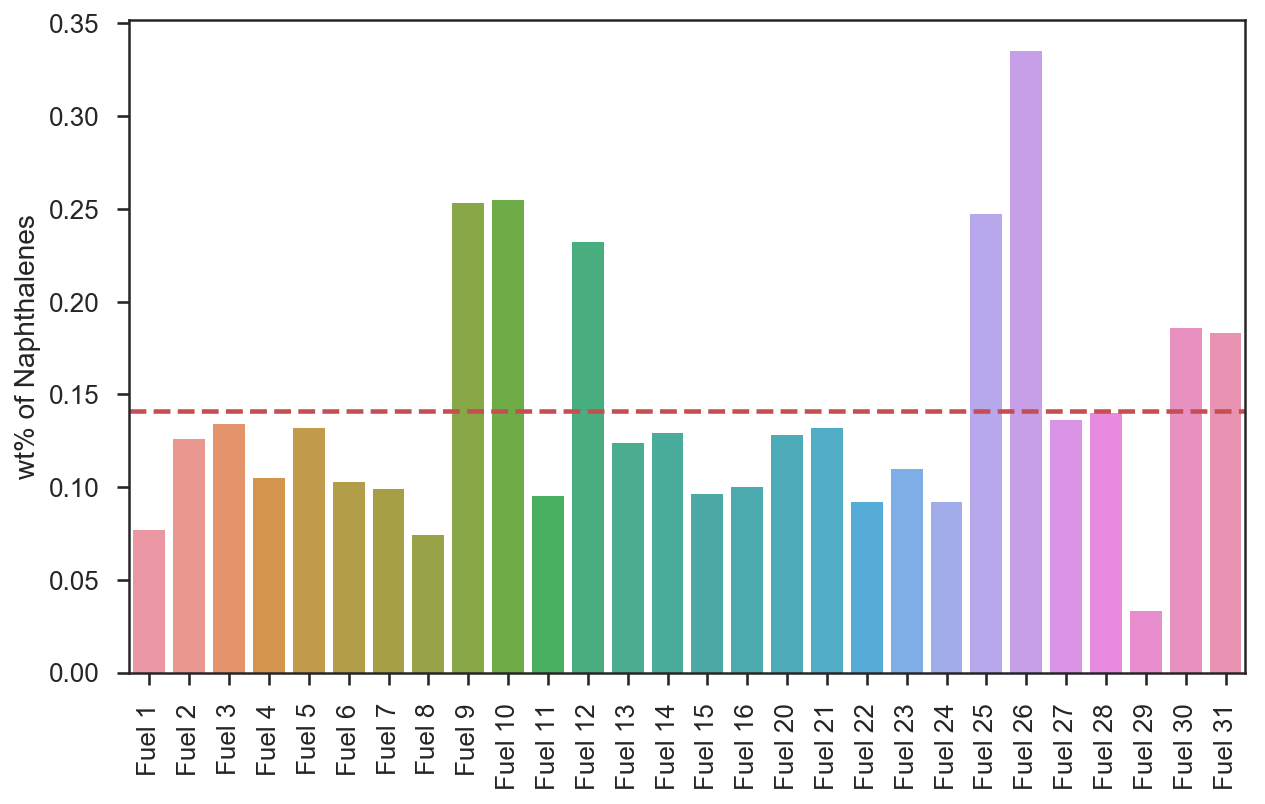

In [16]:
plt.figure(figsize=(10, 6))
g = sns.barplot(x='index', y='naphthalenes', data=fuel_group.loc['naphthalenes'].reset_index())
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.gca().axhline(fuel_group.loc['naphthalenes'].mean(), color='r', linestyle='--')
plt.ylabel('wt% of Naphthalenes', fontsize=14)
plt.xlabel('')

Weight fractions of Naphthalenes in the fuels range from 0.03% to 0.33% with an average of 0.14%. This is apparently a very small amount compared to other hydrocarbon groups (>30% for iso-paraffins). So the first assumption does not hold.

**Do naphthalenes content vary significantly across the fuels?**
Since the contents of different hydrocarbon groups are not on the same scale, I calculate *Relative Variance* to facilitate the comparison of the variance for different hydrocarbon groups:
$$Relative Variance = \frac{max - min}{average}$$

In [17]:
rv = ((fuel_group.max(axis=1) - fuel_group.min(axis=1)) / fuel_group.mean(axis=1)).sort_values(ascending=False)
rv

Group
oxygenates                 6.130266
naphtheno/olefino-benzs    2.553064
naphthalenes               2.141844
mono-naphthenes            2.056801
unidentified               1.981235
indenes                    1.677606
paraffin                   1.461841
i-paraffins                1.451660
n-olefins                  1.404768
di-olefins                 1.357384
mono-aromatics             1.236026
naphtheno-olefins          1.181590
iso-olefins                1.089115
dtype: float64

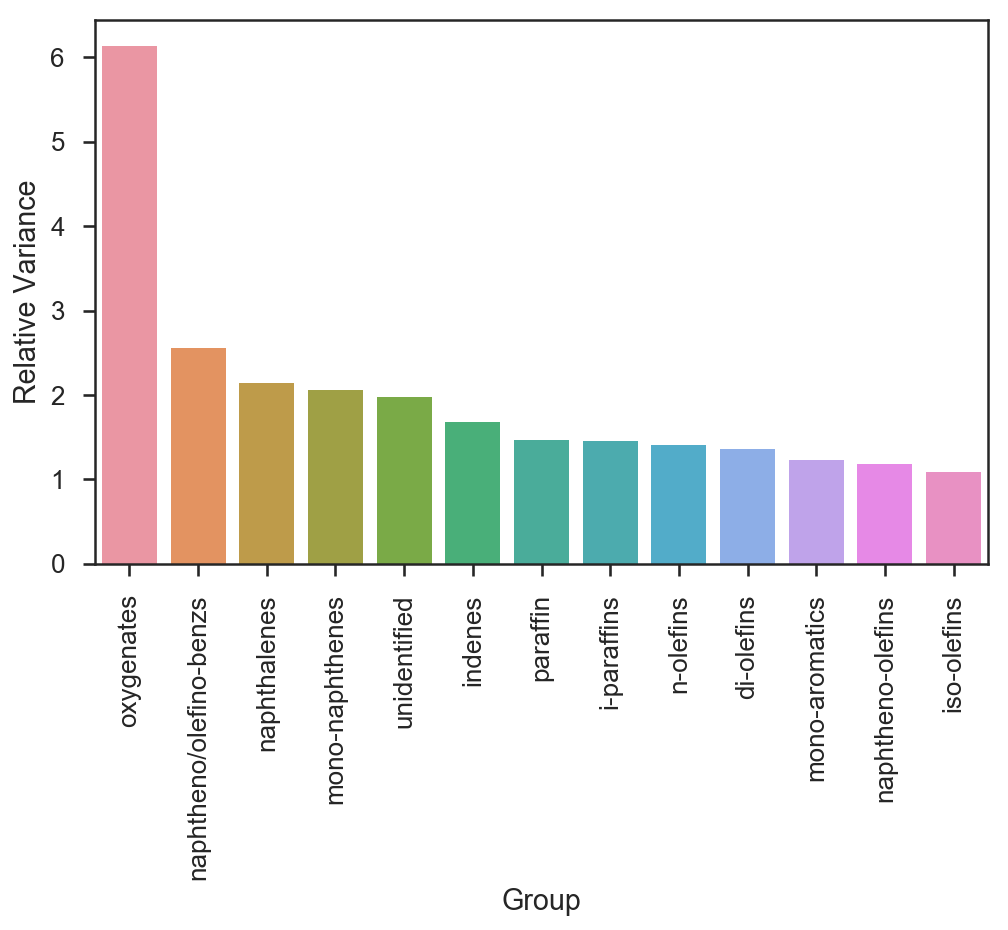

In [18]:
plt.figure(figsize=(8, 5))
g = sns.barplot(x='Group', y=0, data=rv.reset_index())
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_ylabel('Relative Variance')

It is obvious that:
1. The variance of oxygenates (ethanol) is the largest among all hydrocarbon groups.
2. Relative variance of naphthalenes is comparable to other hydrocarbon groups.
Therefore the second assumption also does not hold.  

The only possibility is that naphthalenes have chemical relations with PM formulation. This is indeed the case since soots emitted from fuel combustion is polyaromatic hydrocarbons (PAH), and naphthalenes are precursor of PAHs because it has multiple benzene rings in its chemical structure. From this analysis, **even if we did not know in advance that naphthalenes are precursors of PHAs, we would infer underlying relationship between naphthalenes and soot formation from the above analysis**. This is the power of data analysis and how it can guide scientific research.

## Looking at fuel properties
The second goal is to understand how fuel properties affect PM emission. This can also be considered another way of investigating the impact of ethanol content on fuel PM emission is to look at fuel properties (ethanol content is reported as a fuel property). For this purpose a linear model is developed to predict the PM emission from fuel properties. For the model to be stable, it is desirable to use properties that are not highly correlated with each other.

In [19]:
fuel_props.corr()

,"Density, 60oF","API Gravity, 60oF",Ethanol,Distillation IBP,0.05,0.1,0.2,0.3,0.4,0.5,...,MON,(RON+MON)/2,C,H,O,Net Heat of Combustion,Water,Lead,Solvent Washed Gum Content,Total_pmi
"Density, 60oF",1.000000,-0.999721,0.478788,0.283684,0.298837,0.256439,0.069933,-0.137942,-0.212980,-0.129771,...,0.281242,0.574930,-0.207051,-0.893176,0.454575,-0.667801,0.486584,0.339475,0.135882,0.492310
"API Gravity, 60oF",-0.999721,1.000000,-0.480918,-0.283140,-0.298172,-0.254495,-0.065366,0.144163,0.218230,0.130489,...,-0.282968,-0.577878,0.209355,0.892148,-0.457148,0.669416,-0.486973,-0.335375,-0.140952,-0.495331
Ethanol,0.478788,-0.480918,1.000000,0.404888,0.362934,0.229488,-0.110294,-0.420816,-0.595817,-0.562226,...,0.663988,0.790791,-0.952223,-0.208799,0.999390,-0.965791,0.977865,0.501778,-0.062781,-0.111846
Distillation IBP,0.283684,-0.283140,0.404888,1.000000,0.948892,0.826767,0.364303,-0.064664,-0.188622,0.010602,...,0.100749,0.175372,-0.430546,0.042297,0.401092,-0.399749,0.433546,0.139072,0.033627,-0.192567
0.05,0.298837,-0.298172,0.362934,0.948892,1.000000,0.954256,0.593032,0.161765,0.017491,0.186722,...,0.160052,0.215614,-0.388658,0.057334,0.358999,-0.358978,0.379556,0.199397,0.109577,-0.277315
0.1,0.256439,-0.254495,0.229488,0.826767,0.954256,1.000000,0.803289,0.435362,0.286758,0.372948,...,0.141413,0.157481,-0.262618,0.102563,0.224431,-0.226155,0.237929,0.213936,0.151830,-0.295098
0.2,0.069933,-0.065366,-0.110294,0.364303,0.593032,0.803289,1.000000,0.879098,0.768767,0.660384,...,0.101525,0.010585,0.058373,0.199589,-0.115944,0.122850,-0.116176,0.169015,0.166354,-0.271095
0.3,-0.137942,0.144163,-0.420816,-0.064664,0.161765,0.435362,0.879098,1.000000,0.964855,0.723148,...,-0.015258,-0.177103,0.356988,0.246543,-0.425734,0.438026,-0.425225,0.042953,0.108723,-0.174897
0.4,-0.212980,0.218230,-0.595817,-0.188622,0.017491,0.286758,0.768767,0.964855,1.000000,0.763282,...,-0.141311,-0.308915,0.538552,0.231960,-0.600205,0.594331,-0.607468,-0.083302,0.117163,-0.103457
0.5,-0.129771,0.130489,-0.562226,0.010602,0.186722,0.372948,0.660384,0.723148,0.763282,1.000000,...,-0.092101,-0.245414,0.531618,0.204476,-0.565950,0.550828,-0.583847,-0.295635,0.315735,-0.046575


Linear models may not be able to captures nonlinear interations between features. Thus product and quotient between each pair of features are also considered. However, this interation is limited to two features each time to avoid overfitting. In other words, product of three features is not allowed.

In [20]:
X = fuel_props[['Density, 60oF', 'Distillation                         IBP', '0.7', '(RON+MON)/2', 
                'Saturates', 'Aromatics', 'Ethanol', 'Total_pmi']].copy()
X.columns = ['Density', 'Boiling_Point', 'T70', '(RON+MON)/2', 'Saturates', 'Aromatics', 'Ethanol', 'Total_pmi']
y = fuel_emis.copy().reindex(X.index)

X_inv = 1/X
X_inv.columns = X.columns+'_inv'
X1 = X.join(X_inv)
X1.head()

,Density,Boiling_Point,T70,(RON+MON)/2,Saturates,Aromatics,Ethanol,Total_pmi,Density_inv,Boiling_Point_inv,T70_inv,(RON+MON)/2_inv,Saturates_inv,Aromatics_inv,Ethanol_inv,Total_pmi_inv
Fuel,,,,,,,,,,,,,,,,
1,0.721100,92.880000,224.140000,90.55,66.968000,15.4,10.03,0.959927,1.386770,0.010767,0.004461,0.011044,0.014933,0.064935,0.099701,1.041745
2,0.722025,83.533333,271.716667,92.30,79.100000,14.1,0.05,1.414150,1.384994,0.011971,0.003680,0.010834,0.012642,0.070922,20.000000,0.707139
3,0.734950,106.400000,243.550000,92.80,67.044000,15.0,10.36,0.967959,1.360637,0.009398,0.004106,0.010776,0.014916,0.066667,0.096525,1.033102
4,0.734625,89.857143,269.957143,92.35,67.768000,15.5,9.94,1.396851,1.361239,0.011129,0.003704,0.010828,0.014756,0.064516,0.100604,0.715896
5,0.757325,94.125000,258.450000,91.50,58.385714,34.7,0.05,1.401121,1.320437,0.010624,0.003869,0.010929,0.017127,0.028818,20.000000,0.713714


0.905573000572


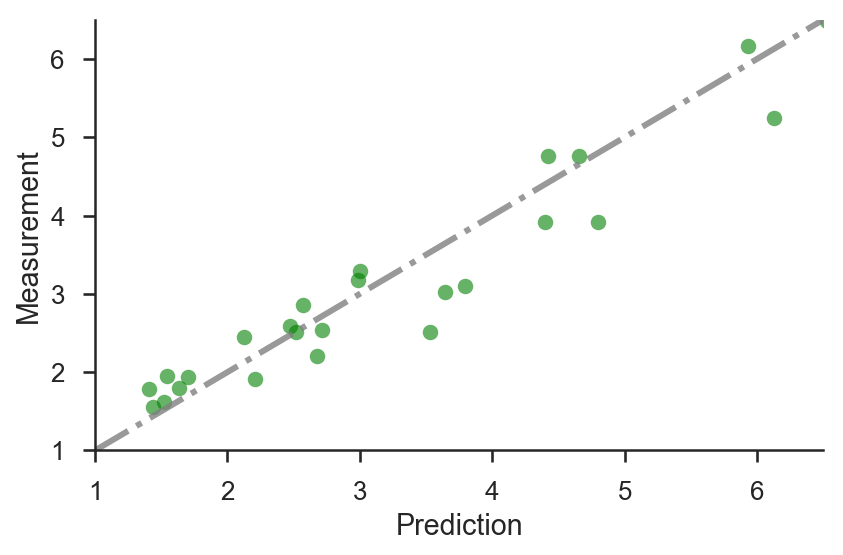

In [21]:
pipe = Pipeline([
    ('interact', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scl', StandardScaler()),
    ('sel', SelectKBest(f_regression, k=2)),
    ('lr', LinearRegression())
])

pipe.fit(X1, y)
sns.regplot(pipe.predict(X1), y.values, fit_reg=False, scatter_kws={'s': 60, 'color': 'green', 'alpha': 0.6})
plt.xlim([1, 6.5])
plt.ylim([1, 6.5])
plt.plot([1, 6.5], [1, 6.5], c='grey', ls='-.', lw=3, alpha=0.8)
sns.despine()
plt.gca().set_xlabel('Prediction')
plt.gca().set_ylabel('Measurement')
plt.tight_layout()
print(pipe.score(X1, y))

Check what are the important features selected by the model.

In [22]:
feature_names=np.asarray(pipe.steps[0][-1].get_feature_names(X1.columns))
sel = feature_names[pipe.steps[2][-1].get_support()]
sel

array(['(RON+MON)/2 Total_pmi', 'Total_pmi Saturates_inv'],
      dtype='<U33')

This linear relationship is then used to check their applicability on the original data with various combinations of test fuels and test vehicles. However, as shown above, the emissions depend heavily on both fuels and vehicles. This model use only information from fuels, therefore the residuals are calculated for each test vehicle separately.

In [23]:
data = emission.merge(X, left_on='Fuel', right_index=True)

In [24]:
def reg_features(selected, df=data):
    dfs = {}
    sel = ['Density', 'Boiling_Point', 'T70', '(RON+MON)/2', 'Saturates', 'Aromatics', 'Ethanol', 'Total_pmi']
    for vehicle in df.Vehicle.unique():
        X = df[df.Vehicle==vehicle]
        fuels = X['Fuel']
        y = X['Emission']
        X = X[sel]
        X_log = np.log(X)
        X_log.columns = X.columns+'_log'
        X_inv = 1/X
        X_inv.columns = X.columns+'_inv'
        X = X.join(X_log).join(X_inv)
        
        for s in selected:
            f = s.split()
            if len(f) == 2:
                X[s] = X[f[0]] * X[f[1]]
            if len(f) == 3:
                X[s] = X[f[0]] * X[f[1]] * X[f[2]]
        dfs[vehicle] = (X[selected], y, fuels.values)

    res = pd.DataFrame()
    for vehicle in df.Vehicle.unique():
        X = dfs[vehicle][0]
        y = dfs[vehicle][1]
        fuels = dfs[vehicle][2]
        lr = LinearRegression()
        lr.fit(X, y)
        res = pd.concat((res, pd.DataFrame({'Measure': y, 'Prediction': lr.predict(X), 'Residual': y-lr.predict(X), 'Vehicle': vehicle, 'Fuel': fuels}),))
    return res

In [25]:
res = reg_features(sel)

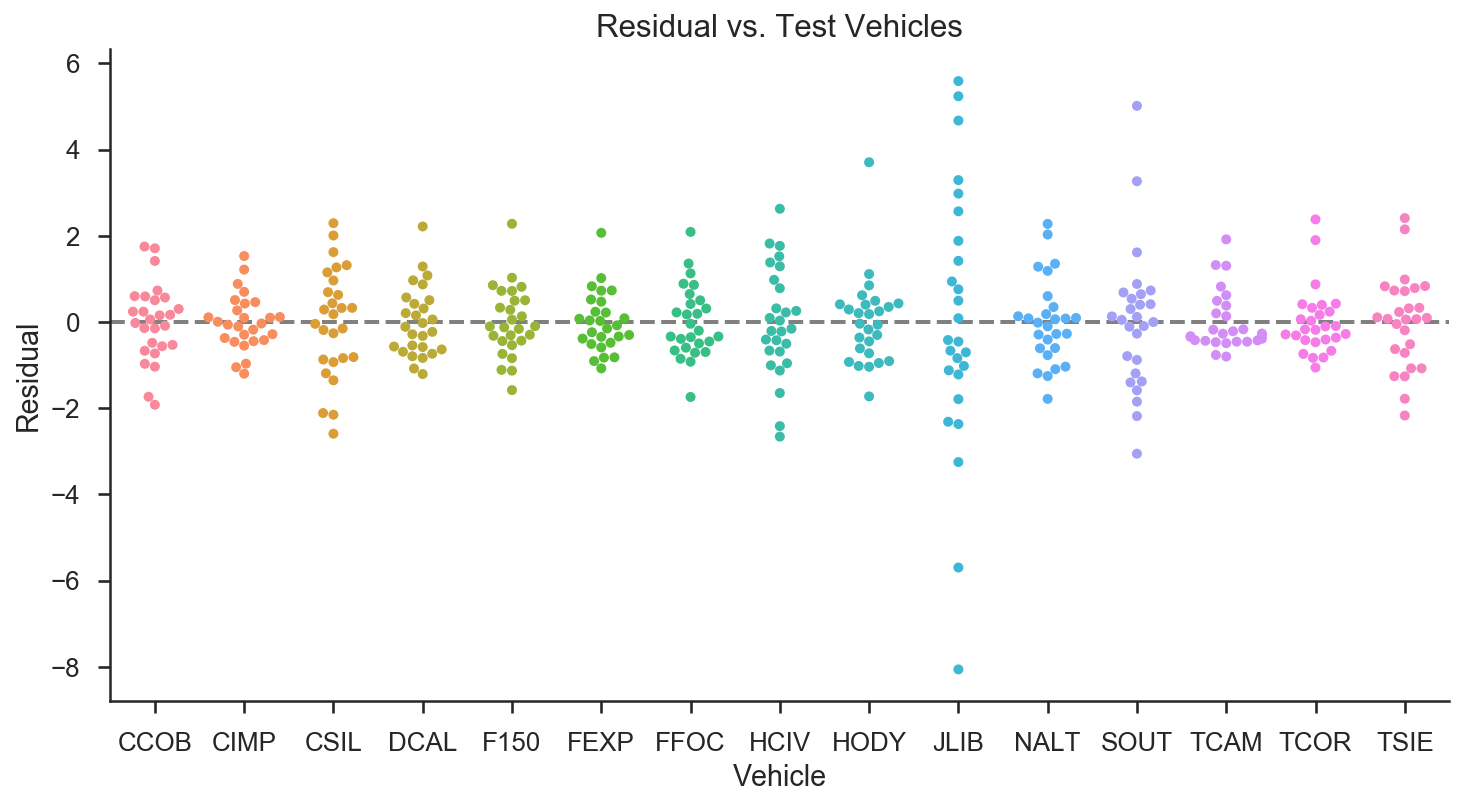

In [26]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='Vehicle', y='Residual', data=res)
plt.axhline(0, c='grey', ls='--', lw=2)
sns.despine()
plt.gca().set_title('Residual vs. Test Vehicles')

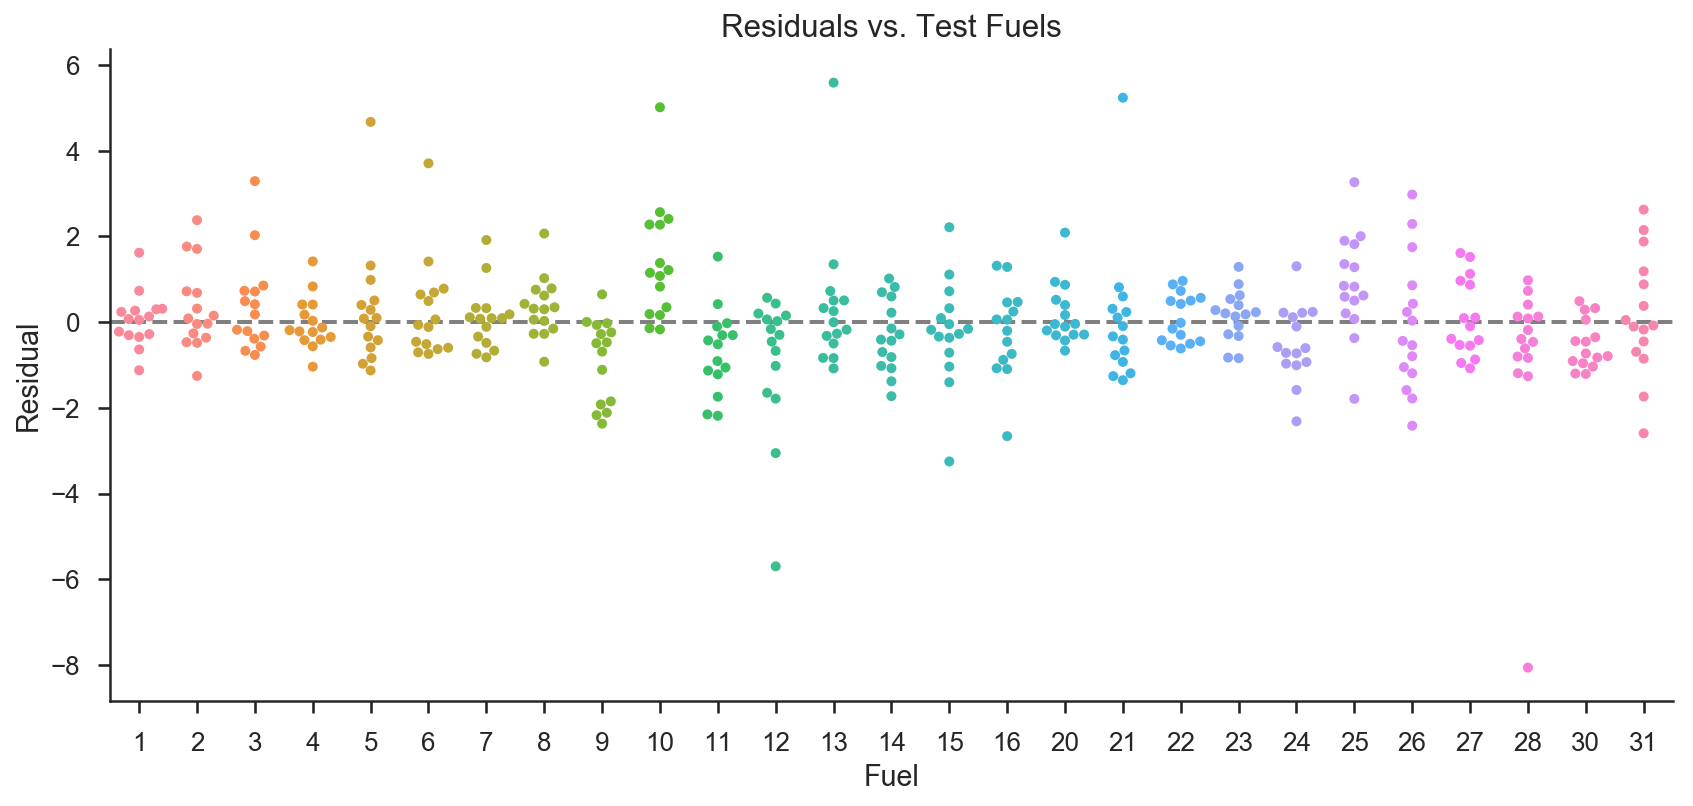

In [27]:
plt.figure(figsize=(14, 6))
sns.swarmplot(x='Fuel', y='Residual', data=res, order=np.sort(res.Fuel.unique()))
plt.axhline(0, c='grey', ls='--', lw=2, zorder=0)
sns.despine()
plt.title('Residuals vs. Test Fuels')

Overall the model captures the trend of PM emissions. The residuals are randomly located on both sides of the zero residual line. However, residuals for some tests are large. This could be attributed to the facts that 
1. this model does not consider vehicle effect
2. some outliers that should be removed still exist in the dataset
3. fuel emission is a complicated chemical process that cannot be fully captured by a linear model.

The results confirms that ethanol is not responsible for PM emissions.